# Image Generation with VQGAN and CLIP

This notebook is a simple implementation of the [VQGAN](https://github.com/CompVis/taming-transformers) and [CLIP](https://github.com/openai/CLIP) models for generating images from text prompts. The code is based on the [tutorial](https://colab.research.google.com/drive/1qnV7PT1aSwomXvRmdoY_pgcR2ruvm6Of?usp=sharing) from John Whitewalker.


# Set up

In [ ]:
print("Downloading CLIP and installing requirements...")

# Clone the CLIP repository from OpenAI's GitHub
!git clone https://github.com/openai/CLIP &> /dev/null

# Install the required packages
!pip install -q  ftfy==6.1.1 regex==2022.4.24 tqdm==4.64.1 omegaconf==2.2.1 pytorch-lightning==2.2.1

print("Setup complete.")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.0/764.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 1.5 MB/s eta 0:00:00
Setup complete.


In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from CLIP import clip # The clip model

In [ ]:
print('Installing a few more libraries')
!git clone https://github.com/CompVis/taming-transformers &> /dev/null # Clone the VQGAN repository
!pip install einops                                       &> /dev/null 
from omegaconf import OmegaConf

import sys
sys.path.append('/content/taming-transformers') # Add the VQGAN path to the system path

# Authors used torch.six.string_classes which is deprecated in latest versions of PyTorch. So we will replace it with str
import fileinput
file_path = '/content/taming-transformers/taming/data/utils.py'

for line in fileinput.input(file_path, inplace=True):
    # Replace the import statement with the assignment
    print(line.replace('from torch._six import string_classes', 'string_classes = str'), end='')

from taming.models import cond_transformer, vqgan

Installing a few libraries


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading the pre-trained VQGAN model weights. Its better to download the files and save it in your drive for later use.
# print('Downloading ImageNet 16384 checkpoints')
# !curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
# !curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

# Move the files to drive for later use or else you will have to download files everytime you run the colab
# !cp vqgan_imagenet_f16_16384.yaml 'drive/MyDrive/vqgan_imagenet_f16_16384.yaml'
# !cp vqgan_imagenet_f16_16384.ckpt 'drive/MyDrive/vqgan_imagenet_f16_16384.ckpt'


In [ ]:
# Move the the pre-trained VQGAN model weights  and config files from drive to colab
!cp 'drive/MyDrive/vqgan_imagenet_f16_16384.yaml' vqgan_imagenet_f16_16384.yaml
!cp 'drive/MyDrive/vqgan_imagenet_f16_16384.ckpt' vqgan_imagenet_f16_16384.ckpt

# Miscelleneous functions for VQGAN+CLIP Model

In [ ]:
def load_vqgan_model(config_path, checkpoint_path):
    """
    Load the VQGAN model from a configuration file and a checkpoint.

    Args:
        config_path (str): Path to the model configuration file.
        checkpoint_path (str): Path to the model checkpoint.

    Returns:
        model: The loaded VQGAN model.
    """
    config = OmegaConf.load(config_path)  # Load the model configuration
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)  # Initialize VQModel
        model.eval().requires_grad_(False)  # Set the model to evaluation mode
        model.init_from_ckpt(checkpoint_path)  # Initialize the model with the checkpoint
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)  # Initialize the transformer model
        parent_model.eval().requires_grad_(False)  # Set to evaluation mode
        parent_model.init_from_ckpt(checkpoint_path)  # Load checkpoint
        model = parent_model.first_stage_model  # Extract the first stage model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')  # Raise error for unknown model type
    del model.loss  # Remove loss attribute from the model
    return model  # Return the loaded model

class ReplaceGrad(torch.autograd.Function):
    """
    A custom autograd function that replaces the gradient of the quantized representation (z_q)
    during backpropagation. This allows the model to optimize the original input tensor while
    preventing the quantized values from affecting the gradient flow, thus preserving the
    optimization dynamics of the input tensor in the training process.
    """
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape  # Store the shape of the backward tensor
        return x_forward  # Return the forward tensor

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)  # Return None for x_forward and modified gradient for x_backward


replace_grad = ReplaceGrad.apply  # Alias for the custom function

class ClampWithGrad(torch.autograd.Function):
    """
    Custom autograd function to clamp values with gradient flow control.

    This function clamps the input tensor values between specified min and max values
    while allowing gradients to flow for values that are not clamped.
    """
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min  # Store min value
        ctx.max = max  # Store max value
        ctx.save_for_backward(input)  # Save input for backward pass
        return input.clamp(min, max)  # Clamp the input values

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors  # Retrieve saved input tensor
        # Calculate gradient for the clamped regions
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None


clamp_with_grad = ClampWithGrad.apply  # Alias for the custom clamping function

def vector_quantize(x, codebook):
    """
    Perform vector quantization.

    This function quantizes the input tensor `x` by finding the nearest codebook entries.

    Args:
        x (Tensor): Input tensor to quantize.
        codebook (Tensor): Tensor representing the codebook for quantization.

    Returns:
        Tensor: Quantized tensor with gradients replaced.
    """
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T  # Compute distances
    indices = d.argmin(-1)  # Find indices of the nearest codebook entries
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook  # Quantize using one-hot encoding
    return replace_grad(x_q, x)  # Return quantized tensor with replaced gradients

def synth(z):
    """
    Synthesize an image from the latent representation.

    This function decodes the quantized latent representation into an image.

    Args:
        z (Tensor): Latent representation tensor.

    Returns:
        Tensor: Synthesized image tensor in the range [0, 1].
    """
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)  # Quantize latent representation
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)  # Decode and clamp the image values

def rand_z(width, height):
    """
    Generate a random latent representation.

    This function creates a random latent vector by sampling from the codebook.

    Args:
        width (int): Width of the output image.
        height (int): Height of the output image.

    Returns:
        Tensor: Random latent representation tensor.
    """
    f = 2**(model.decoder.num_resolutions - 1)  # Calculate downsampling factor
    toksX, toksY = width // f, height // f  # Calculate token dimensions
    n_toks = model.quantize.n_e  # Number of tokens in the codebook
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()  # Generate one-hot encoded tensor
    z = one_hot @ model.quantize.embedding.weight  # Initialize latent representation from codebook
    z = z.view([-1, toksY, toksX, model.quantize.e_dim]).permute(0, 3, 1, 2)  # Reshape and permute dimensions
    return z  # Return the latent representation


# VQGAN Inference 

In [ ]:
# Define device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Define the model
model = load_vqgan_model('vqgan_imagenet_f16_16384.yaml', 'vqgan_imagenet_f16_16384.ckpt').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


We will download an image. Enode it first and then decode to obtain the output image for qualitatively evaluating the VQGAN model.

In [ ]:
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" >> /dev/null
im = Image.open('/content/cat.jpeg').convert('RGB').resize((256, 256))
im = torch.tensor(np.array(im)).permute(2, 0, 1)/255 # Change (H,W,C) format to (C,H,W) and normalize it to range [0 1]
im = im.unsqueeze(0).to(device) * 2 - 1 # The encoder expects inputs in the range (-1, 1)

# Encode the image
z, *_ = model.encode(im)
print('Image shape:', im.shape)
print('Z shape:', z.shape)

# Decode the image
out = synth(z)
print('Output Image shape is :', out.shape)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56693  100 56693    0     0   437k      0 --:--:-- --:--:-- --:--:--  435k
Image shape: torch.Size([1, 3, 256, 256])
Z shape: torch.Size([1, 256, 16, 16])


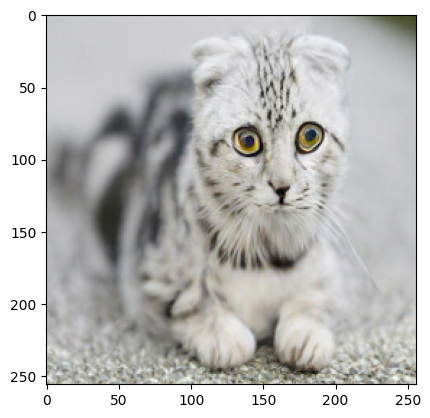

In [ ]:
# Visualize the image
plt.imshow(out.detach().cpu().squeeze().permute(1, 2, 0))

# Generating new images using VQGAN (withouth CLIP)
Generating new images using randomized latent vectors didn't work well for me. 

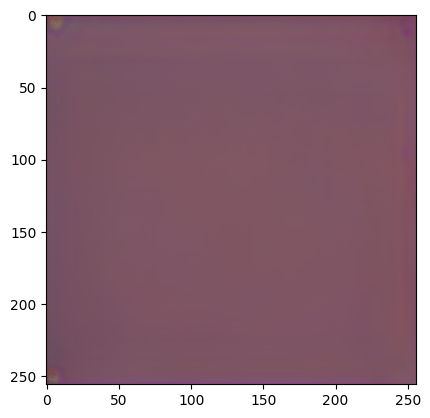

In [22]:
z = torch.rand(1, 256, 16, 16).to(device) # Random latent representation
out = synth(z)
plt.imshow(out.detach().cpu().squeeze().permute(1, 2, 0))

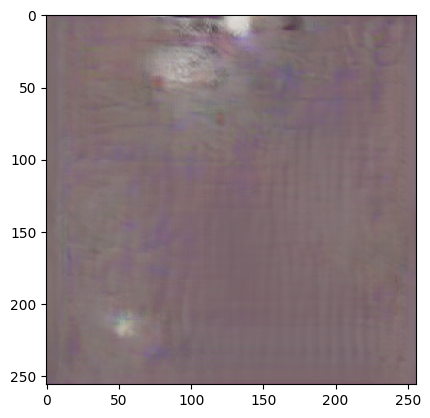

In [23]:
z = rand_z(256, 256) # generate random latent representation based on the image size
out = synth(z)
plt.imshow(out.detach().cpu().squeeze().permute(1, 2, 0))

# # Generating new images using VQGAN + CLIP

In [24]:
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device) # Load the CLIP model
print(perceptor.visual.input_resolution) # 224px a side

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 178MiB/s]


224


In [25]:
# Define the clip loss 
def clip_loss(im_embed, text_embed):
  im_normed = F.normalize(im_embed.unsqueeze(1), dim=2)
  text_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
  dists = im_normed.sub(text_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
  return dists.mean()

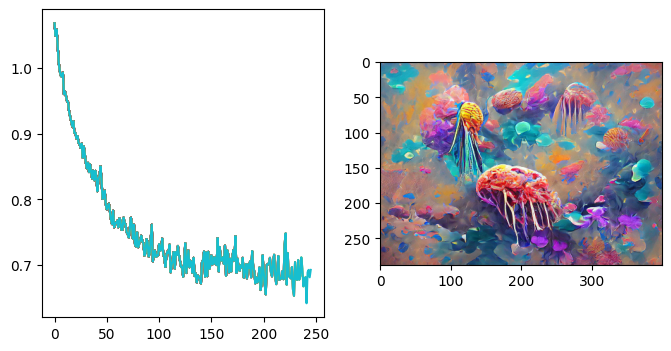

In [27]:
'''
In the following code, we will optimize a random latent representation to match a given text prompt.
The latent representation will be optimized using the CLIP loss, which measures the similarity between the generated image and the text prompt.
The encode_text function is used to encode the text prompt and the encode_image function is used to encode the generated image which is then used to calculate the CLIP loss.
'''

prompt_text = "A colorful painting of a jellyfish by a coral reef, trending on artstation "
width = 400
height = 300
lr = 0.1
n_iter = 250
crops_per_iteration = 8

# Create a transform - this will map the image data to the same range as that seen by CLIP during training
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])

# The transforms to get variations of our image
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

# The z we'll be optimizing
z = rand_z(width, height)
# z = torch.rand(1, 256, 16, 16).to(device)
z.requires_grad=True

# The text target
text_embed = perceptor.encode_text(clip.tokenize(prompt_text).to(device)).float()

# The optimizer. Note that we are only optimizing the z tensor
optimizer = torch.optim.Adam([z], lr=lr, weight_decay=1e-6)

losses = []

# A folder to save results
!rm -r steps
!mkdir steps

# Display for showing progress
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
p = display(fig, display_id=True)

# The optimization loop:
for i in tqdm(range(n_iter)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Get the GAN output
  output = synth(z)

  # Calculate our loss across several different random crops/transforms
  loss = 0
  for _ in range(crops_per_iteration):
    image_embed = perceptor.encode_image(tfms(normalize(output)).to(device)).float()
    loss += clip_loss(image_embed, text_embed)/crops_per_iteration

  # Store loss
  losses.append(loss.detach().item())

  # Save image
  im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)
  Image.fromarray(im_arr).save(f'steps/{i:04}.jpeg')

  # Update plots
  if i % 5 == 0: # Saving time
    axs[0].plot(losses)
    axs[1].imshow(im_arr)
    p.update(fig)

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

ipd.clear_output()

In [28]:
#@title Show Video
!ffmpeg -v 0 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v h264_nvenc -preset slow -qp 18 -pix_fmt yuv420p progress_video.mp4
from IPython.display import HTML
from base64 import b64encode
mp4 = open('progress_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)